<a href="https://colab.research.google.com/github/NoobCoder-dweeb/AI-HandsOn-Journey/blob/main/notes/Proximal_Policy_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install -q torch gymnasium lightning

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.distributions import Categorical
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gymnasium as gym
from collections import deque

/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:596: UserWarning: WARN: plugin: shimmy.registration:register_gymnasium_envs raised Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py", line 594, in load_plugin_envs
    fn()
  File "/usr/local/lib/python3.11/dist-packages/shimmy/registration.py", line 304, in register_gymnasium_envs
    _register_atari_envs()
  File "/usr/local/lib/python3.11/dist-packages/shimmy/registration.py", line 205, in _register_atari_envs
    import ale_py
  File "/usr/local/lib/python3.11/dist-packages/ale_py/__init__.py", line 68, in <module>
    register_v0_v4_envs()
  File "/usr/local/lib/python3.11/dist-packages/ale_py/registration.py", line 178, in register_v0_v4_envs
    _register_rom_configs(legacy_games, obs_types, versions)
  File "/usr/local/lib/python3.11/dist-packages/ale_py/registration.py", line 63, in _register_rom_configs
    gymnasium.register(
    ^^^^^^^^^^^

In [ ]:
# env_train = gym.make("CartPole-v1")
# env_test = gym.make("CartPole-v1")
from torch.cuda.amp import autocast, GradScaler

device = "cuda:0" if torch.cuda.is_available() else "cpu"

class TrajectoryDataset(Dataset):
    def __init__(self, states, actions, returns, advantages, old_policy_dist):
        self.states = states
        self.actions = actions
        self.returns = returns
        self.advantages = advantages
        self.old_policy_dist = old_policy_dist

    def __len__(self):
        return len(self.states)

    def __getitem__(self, idx):
        return (
            self.states[idx],
            self.actions[idx],
            self.returns[idx],
            self.advantages[idx],
            self.old_policy_dist[idx],
        )

class ActorCritic(nn.Module):
    def __init__(self, observation_dim, action_dim):
        super(ActorCritic, self).__init__()
        self.shared = nn.Sequential(
            nn.Linear(observation_dim, 64),
            nn.ReLU(),
        )

        self.actor = nn.Sequential(
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,action_dim),
            nn.Softmax(dim=-1)
        )
        self.critic = nn.Sequential(
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,1),
        )
    def forward(self, x):
        x = self.shared(x)
        return self.actor(x), self.critic(x)

class PPOAgent(pl.LightningModule):
    def __init__(
        self,
        env_name="CartPole-v1",
        gamma=0.99,
        clip_eps=.2,
        lr=3e-4,
        batch_size=2048,
        epochs=10,
    ):
        super().__init__()
        self.env = gym.make("CartPole-v1")
        self.observation_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.n

        self.device_ = "cuda:0" if torch.cuda.is_available() else "cpu"
        self.model = ActorCritic(self.observation_dim, self.action_dim).to(self.device_)
        self.gamma = gamma
        self.clip_eps = clip_eps
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs
        self.memory = []
        self.dataset = None

    def setup(self, stage=None):
        self.collect_trajectory()

    def collect_trajectory(self):
        obs, _ = self.env.reset()
        self.memory = []
        episode_rewards = []
        ep_reward = 0
        done = False
        while len(self.memory) < self.batch_size:
            obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(self.device_)
            with torch.no_grad():
                probs, value = self.model(obs_tensor)
            old_policy_dist = Categorical(probs)
            action = old_policy_dist.sample().item()
            next_obs, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated
            action_tensor = torch.tensor([action], dtype=torch.int64).to(self.device_)
            log_prob = old_policy_dist.log_prob(action_tensor)

            self.memory.append((obs, action, reward, value.item(), log_prob.item()))
            ep_reward += reward

            obs = next_obs
            if done:
                episode_rewards.append(ep_reward)
                ep_reward = 0
                obs, _ = self.env.reset()
        # store episode returns
        self.episode_returns = episode_rewards

        # after collecting memory
        states, actions, rewards, values, old_policy_dist = zip(*self.memory)
        states = torch.tensor(states, dtype=torch.float32).to(self.device_)
        actions = torch.tensor(actions).to(self.device_)
        returns = torch.tensor(self.compute_rewards(rewards), dtype=torch.float32).to(self.device_)
        values = torch.tensor(values, dtype=torch.float32).to(self.device_)
        old_policy_dist = torch.tensor(old_policy_dist, dtype=torch.float32).to(self.device_)
        advantages = returns - values

        self.dataset = TrajectoryDataset(states, actions, returns, advantages, old_policy_dist)
        self.memory.clear()

    def compute_rewards(self, rewards):
        returns = []
        R = 0
        for r in reversed(rewards):
            R = r + self.gamma * R
            returns.insert(0, R)
        return returns

    def training_step(self, batch, batch_idx):
        states, actions, returns, advantages, old_policy_dist = batch
        states, actions, returns, advantages, old_policy_dist = states.to(self.device_), \
                                                                actions.to(self.device_), \
                                                                returns.to(self.device_), \
                                                                advantages.to(self.device_), \
                                                                old_policy_dist.to(self.device_)

        with torch.amp.autocast(device_type="cuda", dtype=torch.float16): # enable mixed precision
            probs, values_new = self.model(states)
            dist = Categorical(probs)
            new_policy_dist = dist.log_prob(actions)

            ratio = (new_policy_dist - old_policy_dist).exp()
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - self.clip_eps, 1+self.clip_eps)*advantages
            actor_loss = -torch.min(surr1, surr2).mean()
            critic_loss = (returns-values_new.squeeze()).pow(2).mean()

            loss = actor_loss + 0.5 * critic_loss

        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        self.optimizer = Adam(self.model.parameters(), lr=self.lr)
        return self.optimizer

    def train_dataloader(self):
        if self.dataset is None:
            self.collect_trajectory()
        batch_size = 64 if self.device_ == "cpu" else 256
        return DataLoader(self.dataset, batch_size=batch_size, shuffle=True, num_workers=0)

    # def on_train_epoch_end(self):
    #     if hasattr(self, "episode_returns"):
    #         avg_return = np.mean(self.episode_returns)
    #         self.log("avg_return", avg_return, prog_bar=True, on_epoch=True)

In [ ]:
!nproc

4


In [ ]:
logger = CSVLogger("lightning_logs", name="ppo")
model = PPOAgent()
trainer = pl.Trainer(max_epochs=200, log_every_n_steps=1, logger=logger, accelerator="gpu", devices=1, precision=16)
trainer.fit(model)

/usr/local/lib/python3.11/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
/tmp/ipykernel_31/2118411533.py:108: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.tensor(states, dtype=torch.float32).to(self.device_)
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
def get_metrics():
    file = "metrics.csv"
    path_name = "lightning_logs/ppo"
    directory = os.listdir(path_name)
    directory = sorted(directory, key=lambda x: int(x.split("_")[-1])) # sort by latest version
    latest_directory = directory[-1]

    return os.path.join(path_name, latest_directory, file)


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with

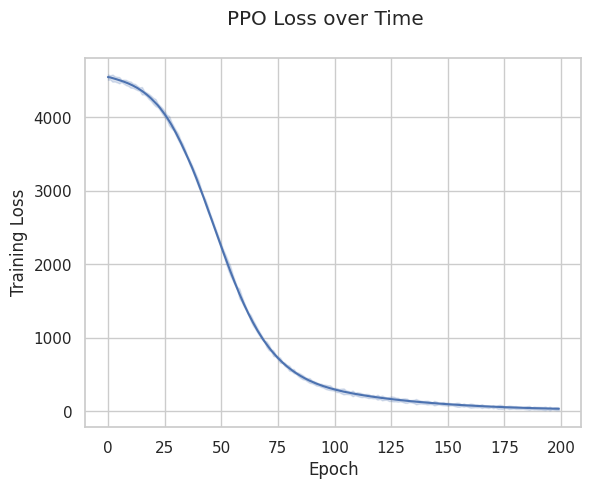

In [ ]:
import pandas as pd
filename = get_metrics()
df = pd.read_csv(filename)
# df = df[df["avg_return"].notna()]
df = df[df["train_loss"].notna()]

sns.set(style="whitegrid")
sns.lineplot(x=df["epoch"], y=df["train_loss"])
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.suptitle("PPO Loss over Time")

# sns.lineplot(x=df["epoch"], y=df["avg_return"])
# plt.xlabel("Epoch")
# plt.ylabel("Average Return")
# plt.suptitle("PPO Performance over Time")
plt.show()